<a href="https://colab.research.google.com/github/Hotckiss/DUL/blob/hw3_2/hw3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import pickle

import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

path_ = os.path.join('drive', 'My Drive', 'hw3-q2.pkl')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
def plot_data(n, train, validate, title_):
    ax = plt.subplot(111)
    ax.plot(range(n), train, label='train')
    ax.plot(range(n), validate, label='val')
    ax.set_xlabel("n")
    ax.set_title(title_)
    ax.legend()

In [0]:
def read_data():
    with open(path_, 'rb') as in_file:
        dataset = pickle.load(in_file)

    return dataset['train'], dataset['valid']

In [0]:
xs_train, xs_val = read_data()

In [0]:
class GatedShortcutConnection(nn.Module):
    def __init__(self, channels=128):
        super(GatedShortcutConnection, self).__init__()
                 
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
                 
    def forward(self, x):
        return self.conv1(x) * self.sigmoid(self.conv2(x))

In [0]:
class ResidualStack(nn.Module):
    def __init__(self, channels=64):
        super(ResidualStack, self).__init__()      
        self.net = nn.Sequential(
            nn.Conv2d(4 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU()
        )
                 
    def forward(self, x):
        return self.net(x)

In [0]:
class Encoder(nn.Module):
    def __init__(self, channels):
        super(Encoder, self).__init__()
        self.channels = channels
        self.net = nn.Sequential(
            nn.Conv2d(3, self.channels * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(self.channels * 4, self.channels * 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            ResidualStack(self.channels),
            nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=1)
        )
                 
    def forward(self, x):
        x = self.net(x).reshape(-1, 2, 2 * self.channels, 8, 8)
        return x[:, 0], torch.exp(x[:, 1])

In [0]:
class Decoder(nn.Module):
    def __init__(self, channels):
        super(Decoder, self).__init__()
        self.channels = channels
        self.layers = nn.Sequential(
            nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            ResidualStack(self.channels),
            nn.ConvTranspose2d(self.channels * 2, self.channels * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels * 2, 3 * 2, kernel_size=4, stride=2, padding=1, bias=False)
        )
                 
    def forward(self, x):
        x = self.layers(x).reshape(-1, 2, 3, 32, 32)
        return x[:, 0], torch.exp(x[:, 1])

In [0]:
class VAE(nn.Module):
    def __init__(self, channels=64):
        super(VAE, self).__init__()
        self.channels = channels
        self.encoder = Encoder(channels)
        self.decoder = Decoder(channels)
            
    def encode(self, x, training=True):
        mu, var = self.encoder(x)
        z = mu + torch.sqrt(var) * torch.randn_like(mu, device=device)
        return (mu, var, z) if training else mu
    
    def decode(self, z):
        return self.decoder(z)
            
    def forward(self, x):
        mu_z, var_z, z = self.encode(x)
        mu_x, var_x = self.decode(z)
        return mu_z, var_z, mu_x, var_x

In [0]:
def MLLLoss(mu, var, x):
    return (0.5 * (torch.log(np.pi * 2 * var) + (x - mu) ** 2 / var)).mean()

In [0]:
def KLDiv(mu, var):
    return (-0.5 * (1.0 + torch.log(var) - mu ** 2 - var)).mean()

In [0]:
def collate_fn(xs):
    return (torch.tensor(xs, dtype=torch.float32) * 2 / 255 - 1).permute(0, 3, 1, 2)

train_data_loader = data.DataLoader(
    dataset=xs_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn
)
val_data_loader = data.DataLoader(
    dataset=xs_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    collate_fn=collate_fn
)

epochs = 2
batch_size = 1024
model = VAE(channels=32)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [0]:
def train():
    losses_mse_train = []
    losses_kl_train = []
    losses_train = []
    losses_mse_val = []
    losses_kl_val = []
    losses_val = []
    for i in trange(epochs):
        losses_mse = []
        losses_kl = []
        losses = []
        model.train()
        for xs in train_data_loader:
            xs = xs.to(device)
            
            optimizer.zero_grad()

            z_data, mu_x, var_x = model(xs)
            
            loss_mse = MLLLoss(mu_x, var_x, xs)
            loss_kl = KLDiv(*z_data)
            loss = loss_mse + loss_kl

            losses_mse.append(loss_mse.item())
            losses_kl.append(loss_kl.item())
            losses.append(loss.item())

            loss.backward()
            optimizer.step()

        losses_mse_train.append(np.array(losses_mse).mean())
        losses_kl_train.append(np.array(losses_kl).mean())
        losses_train.append(np.array(losses).mean())

        losses_mse = []
        losses_kl = []
        losses = []
        model.eval()
        with torch.no_grad():
            for xs in val_data_loader:
                xs = xs.to(device)

                z_data, mu_x, var_x = model(xs)

                loss_mse = MLLLoss(mu_x, var_x, xs)
                loss_kl = KLDiv(*z_data)
                loss = loss_mse + loss_kl

                losses_mse.append(loss_mse.item())
                losses_kl.append(loss_kl.item())
                losses.append(loss.item())

        losses_mse_val.append(np.array(losses_mse).mean())
        losses_kl_val.append(np.array(losses_kl).mean())
        losses_val.append(np.array(losses).mean())

    return losses_mse_train, losses_mse_val, losses_kl_train, losses_kl_val, losses_train, losses_val

In [0]:


losses_mse_train, losses_mse_val, losses_kl_train, losses_kl_val, losses_train, losses_val = train()

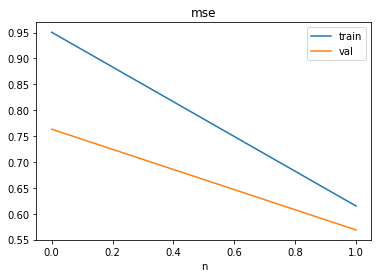

In [24]:
plot_data(epochs, losses_mse_train, losses_mse_val, "mse")

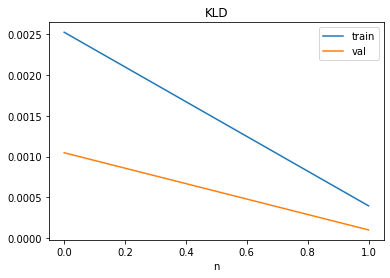

In [25]:
plot_data(epochs, losses_kl_train, losses_kl_val, "KLD")

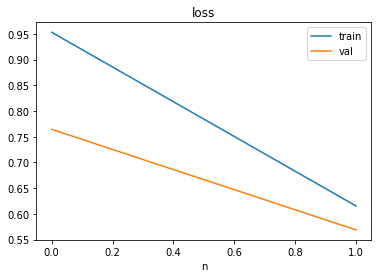

In [26]:
plot_data(epochs, losses_train, losses_val, "loss")